# 1 - Problem Definition & Dataset Creation

## Real-world problem 1: Software quality classification
Software releases can become defect-prone when change volume, churn, and contributor activity increase. The objective is to classify whether a release is defect-prone using process metrics and repository-level GitHub metrics.

## Real-world problem 2: Software effort forecasting
Teams also need release-level effort estimates for planning. Here, effort is approximated using measurable proxies (especially lines added). The objective is to predict next-release effort from current release features.


## 1.1 Load all three tables
Load required libraries and read the three input datasets:
- `github_metrics.csv`
- `process_metrics.csv`
- `release_data.csv`

Then print dataset shapes for a quick integrity check.


In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, KFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, mean_squared_error, r2_score, make_scorer, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.kernel_ridge import KernelRidge
from sklearn.inspection import permutation_importance, PartialDependenceDisplay


github_df = pd.read_csv("github_metrics.csv")
process_df = pd.read_csv("process_metrics.csv")
release_df = pd.read_csv("release_data.csv")

print("github_metrics:", github_df.shape)
print("process_metrics:", process_df.shape)
print("release_data:  ", release_df.shape)

github_metrics: (426, 31)
process_metrics: (62448, 20)
release_data:   (64070, 9)


## 1.2 Clean key columns and deduplicate release table
- Normalize commit hashes to lowercase for reliable joins.
- Parse release dates into `date_parsed`.
- Deduplicate release rows by `(project_name, sha)` and keep the latest dated record.


In [103]:
# Normalize hashes for reliable merging
process_df["current_commit_hash"] = process_df["current_commit_hash"].astype(str).str.lower()
release_df["sha"] = release_df["sha"].astype(str).str.lower()

# Parse release dates (used to sort releases)
release_df["date_parsed"] = pd.to_datetime(release_df["date"], errors="coerce")

# Deduplicate release table: keep one row per (project_name, sha)
# (many repos have multiple tags pointing to the same sha)
release_unique = (
    release_df.sort_values(["project_name", "sha", "date_parsed"])
              .drop_duplicates(subset=["project_name", "sha"], keep="last")
)

print("release_unique:", release_unique.shape)
print("release_unique date coverage:", release_unique["date_parsed"].notna().mean())

release_unique: (47387, 10)
release_unique date coverage: 0.9945554687994598


## 1.3 Merge process, release, and GitHub-level data
- Merge process metrics with release metadata using project + commit hash.
- Merge the result with repository-level GitHub metrics using project name.
- Print match coverage after each merge.


In [104]:
# Merge process metrics with release info
df = process_df.merge(
    release_unique[["project_name", "sha", "tag_name", "date_parsed"]],
    left_on=["project_name", "current_commit_hash"],
    right_on=["project_name", "sha"],
    how="left"
)

print("After process+release merge:", df.shape)
print("Matched release dates:", df["date_parsed"].notna().mean())

# Merge repo-level GitHub metrics using repo id string (apache#repo)
df = df.merge(
    github_df,
    left_on="project_name",
    right_on="full_name",
    how="left",
    suffixes=("", "_repo")
)

print("After adding github metrics:", df.shape)
print("Matched repos:", df["owner"].notna().mean())

After process+release merge: (62448, 23)
Matched release dates: 0.9290769920573918
After adding github metrics: (62448, 54)
Matched repos: 0.9863726620548297


## 1.4 Define targets (classification + forecasting)
- Keep rows with valid release dates and sort releases chronologically within each project.
- Build classification target `defect_prone` from median split of `n_fix`.
- Build forecasting targets by shifting next-release values within each project:
  - `effort_next_lines_added`
  - `effort_next_n_auth`
- Drop each project's final release row (no next-release target available).


In [105]:
# Keep rows with known release dates (needed for correct release ordering)
df = df[df["date_parsed"].notna()].copy()

# Sort releases by time within each project
df = df.sort_values(["project_name", "date_parsed"])

# Classification target: defect-prone based on median n_fix
nfix_median = df["n_fix"].median()
df["defect_prone"] = (df["n_fix"] >= nfix_median).astype(int)

# Forecasting targets: next release effort proxies
df["effort_next_lines_added"] = df.groupby("project_name")["lines_added"].shift(-1)
df["effort_next_n_auth"] = df.groupby("project_name")["n_auth"].shift(-1)

# Drop last release per project (no next release target)
df = df.dropna(subset=["effort_next_lines_added", "effort_next_n_auth"]).copy()

print("Final merged rows (before column cleanup):", df.shape)
print("Defect-prone rate:", df["defect_prone"].mean())

Final merged rows (before column cleanup): (57580, 57)
Defect-prone rate: 0.5125911774921847


## 1.5 Remove non-modeling fields
Drop identifiers and metadata fields (hashes, URLs, IDs, tag metadata) to reduce leakage/noise before modeling.


In [106]:
drop_cols = [
    "previous_commit_hash", "current_commit_hash", "sha",
    "key", "id_json", "url", "html_url", "created_at",
    "tag_name", "exclusion_reason"
]

df_final = df.drop(columns=[c for c in drop_cols if c in df.columns])

print("df_final shape:", df_final.shape)
print("Missing values total:", df_final.isna().sum().sum())
df_final.head(2)

df_final shape: (57580, 50)
Missing values total: 50779


,id,project_name,n_releases,release,total_LOC,t_lines,lines_added,max_lines_added,avg_lines_added,weighted_age,...,num_stars,main_language,num_files,num_methods,num_buggy_files,num_buggy_methods,num_bugs,defect_prone,effort_next_lines_added,effort_next_n_auth
31586,31586,FFmpeg#FFmpeg,405,tag-N,NaN,13216,0,0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,0.0
31587,31587,FFmpeg#FFmpeg,405,tag-N,NaN,13216,0,0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,0.0


## 1.6 Reduce dataset size to ~6000 rows
- Cap rows per project (max 20) to preserve project diversity.
- Stratified downsample to exactly 6000 rows using `defect_prone`.


In [107]:
RANDOM_STATE = 42
rng = np.random.RandomState(RANDOM_STATE)

# cap per project while keeping project_name
capped = (
    df_final.assign(_rand=rng.rand(len(df_final)))
            .sort_values(["project_name", "_rand"])
            .groupby("project_name", group_keys=False)
            .head(20)
            .drop(columns=["_rand"])
)

print("After per-project cap:", capped.shape)

# downsample to exactly 6000 rows with stratification on defect_prone
sample_6000, _ = train_test_split(
    capped,
    train_size=6000,
    stratify=capped["defect_prone"],
    random_state=RANDOM_STATE
)

print("Final sample:", sample_6000.shape)
print("Defect-prone rate (sample):", sample_6000["defect_prone"].mean())

After per-project cap: (7317, 50)
Final sample: (6000, 50)
Defect-prone rate (sample): 0.6371666666666667


## 1.7 Save final local datasets
Export:
- `final_merged_dataset.csv` (full cleaned merged set)
- `final_dataset_6000.csv` (sampled modeling set)


In [108]:
df_final.to_csv("final_merged_dataset.csv", index=False)
sample_6000.to_csv("final_dataset_6000.csv", index=False)

print("Saved: final_merged_dataset.csv")
print("Saved: final_dataset_6000.csv")

Saved: final_merged_dataset.csv
Saved: final_dataset_6000.csv


## 1.8 Inspect missing values
Reload the sampled dataset and compute a sorted missing-value summary.


In [109]:
df = pd.read_csv("final_dataset_6000.csv")

missing_summary = df.isna().sum().sort_values(ascending=False)
missing_summary[missing_summary > 0]

total_LOC            1559
language              252
num_contributors      236
fork                  236
archived              236
disabled              236
watchers_count        236
stargazers_count      236
forks_count           236
has_issues            236
repo_name             236
size                  236
updated_at            236
pushed_at             236
full_name             236
owner                 236
id_repo               236
num_files             236
num_bugs              236
sbom_flag             236
num_commits           236
num_buggy_commits     236
lifetime_days         236
num_languages         236
num_stars             236
main_language         236
num_buggy_files       236
num_methods           236
num_buggy_methods     236
release                 1
dtype: int64

## 2.1 Load features and define targets
- Define classification target: `defect_prone`
- Define regression target: `effort_next_lines_added`
- Build feature matrix `X` by removing target columns


In [110]:
# Targets
y_class = df["defect_prone"]
y_reg = df["effort_next_lines_added"]

# Features (remove both targets)
X = df.drop(columns=["defect_prone", "effort_next_lines_added", "effort_next_n_auth"])

print("X shape:", X.shape)
print("Classification target shape:", y_class.shape)
print("Regression target shape:", y_reg.shape)

X shape: (6000, 47)
Classification target shape: (6000,)
Regression target shape: (6000,)


## 2.2 Train/test split (stratified)
Create one shared train/test split for both tasks using stratification on the classification label to preserve class balance.


In [111]:
X_train, X_test, y_class_train, y_class_test, y_reg_train, y_reg_test = train_test_split(
    X,
    y_class,
    y_reg,
    test_size=0.2,
    stratify=y_class,  # maintain defect class balance
    random_state=42
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)
print("Train defect rate:", y_class_train.mean())
print("Test defect rate:", y_class_test.mean())

Train shape: (4800, 47)
Test shape: (1200, 47)
Train defect rate: 0.6370833333333333
Test defect rate: 0.6375


## 2.3 Inspect column types
Check feature dtypes, counts by dtype, and explicit categorical/numeric column lists.


In [112]:
print(X_train.dtypes.astype(str).sort_values())

num_bugs             float64
id_repo              float64
forks_count          float64
stargazers_count     float64
avg_change_set       float64
watchers_count       float64
avg_churn            float64
num_contributors     float64
num_commits          float64
n_auth               float64
num_buggy_commits    float64
weighted_age         float64
avg_lines_added      float64
lifetime_days        float64
num_languages        float64
num_stars            float64
total_LOC            float64
num_files            float64
num_methods          float64
num_buggy_files      float64
size                 float64
num_buggy_methods    float64
id                     int64
max_churn              int64
n_releases             int64
age                    int64
max_change_set         int64
t_lines                int64
lines_added            int64
max_lines_added        int64
n_fix                  int64
churn                  int64
project_name          object
release               object
main_language 

In [113]:
print(X_train.dtypes.value_counts())
print("\nCategorical columns:")
print(X_train.select_dtypes(include=["object", "string"]).columns.tolist())

print("\nNumeric columns:")
print(X_train.select_dtypes(include=["int64","float64"]).columns.tolist())

float64    22
object     15
int64      10
Name: count, dtype: int64

Categorical columns:
['project_name', 'release', 'date_parsed', 'full_name', 'owner', 'repo_name', 'updated_at', 'pushed_at', 'language', 'has_issues', 'archived', 'disabled', 'fork', 'sbom_flag', 'main_language']

Numeric columns:
['id', 'n_releases', 'total_LOC', 't_lines', 'lines_added', 'max_lines_added', 'avg_lines_added', 'weighted_age', 'n_fix', 'n_auth', 'churn', 'max_churn', 'avg_churn', 'max_change_set', 'avg_change_set', 'age', 'id_repo', 'size', 'forks_count', 'stargazers_count', 'watchers_count', 'num_contributors', 'num_commits', 'num_buggy_commits', 'lifetime_days', 'num_languages', 'num_stars', 'num_files', 'num_methods', 'num_buggy_files', 'num_buggy_methods', 'num_bugs']


## 3.1 Drop identifier-style feature columns
Remove remaining identifier/time metadata columns from train and test features.


In [114]:
drop_cols = [
    "release",
    "date_parsed",
    "full_name",
    "owner",
    "repo_name",
    "updated_at",
    "pushed_at",
    "id",
    "id_repo"
]

X_train = X_train.drop(columns=[c for c in drop_cols if c in X_train.columns])
X_test = X_test.drop(columns=[c for c in drop_cols if c in X_test.columns])

print("New shape after dropping IDs:")
print("Train:", X_train.shape)
print("Test:", X_test.shape)

New shape after dropping IDs:
Train: (4800, 38)
Test: (1200, 38)


## 3.2 Re-check categorical vs numeric columns
Recompute and print categorical and numeric feature lists after dropping identifier fields.


In [115]:
print("Categorical columns:")
print(X_train.select_dtypes(include=["object", "string"]).columns.tolist())

print("\nNumeric columns:")
print(X_train.select_dtypes(include=["int64","float64"]).columns.tolist())

Categorical columns:
['project_name', 'language', 'has_issues', 'archived', 'disabled', 'fork', 'sbom_flag', 'main_language']

Numeric columns:
['n_releases', 'total_LOC', 't_lines', 'lines_added', 'max_lines_added', 'avg_lines_added', 'weighted_age', 'n_fix', 'n_auth', 'churn', 'max_churn', 'avg_churn', 'max_change_set', 'avg_change_set', 'age', 'size', 'forks_count', 'stargazers_count', 'watchers_count', 'num_contributors', 'num_commits', 'num_buggy_commits', 'lifetime_days', 'num_languages', 'num_stars', 'num_files', 'num_methods', 'num_buggy_files', 'num_buggy_methods', 'num_bugs']


## 3.3 Define column groups
Store `numeric_cols` and `categorical_cols` for preprocessing.


In [116]:
numeric_cols = X_train.select_dtypes(include=["int64","float64"]).columns.tolist()
categorical_cols = X_train.select_dtypes(include=["object","string"]).columns.tolist()

print("Numeric count:", len(numeric_cols))
print("Categorical count:", len(categorical_cols))

Numeric count: 30
Categorical count: 8


## 3.4 Create preprocessing pipelines
- Numeric pipeline: median imputation + standard scaling
- Categorical pipeline: most-frequent imputation + one-hot encoding
- Combine both using a `ColumnTransformer`


In [117]:
# Pipelines
numeric_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer([
    ("num", numeric_pipeline, numeric_cols),
    ("cat", categorical_pipeline, categorical_cols)
])


print("Numeric:", len(numeric_cols), "Categorical:", len(categorical_cols))

Numeric: 30 Categorical: 8


## 4.1 Baseline classifier: Quadratic Discriminant Analysis (QDA)
Build a pipeline (`preprocessor -> QDA`), fit on training data, and evaluate on test set with Accuracy, F1, and ROC-AUC.


In [118]:
qda_clf = Pipeline([
    ("preprocessor", preprocessor),
    ("model", QuadraticDiscriminantAnalysis(reg_param=0.01))
])

qda_clf.fit(X_train, y_class_train)

y_pred_qda = qda_clf.predict(X_test)
y_proba_qda = qda_clf.predict_proba(X_test)[:, 1]

print("QDA Accuracy:", accuracy_score(y_class_test, y_pred_qda))
print("QDA F1 Score:", f1_score(y_class_test, y_pred_qda))
print("QDA ROC-AUC:", roc_auc_score(y_class_test, y_proba_qda))

QDA Accuracy: 0.6933333333333334
QDA F1 Score: 0.7093206951026856
QDA ROC-AUC: 0.8411163699196154


## 4.2 Baseline regressor: Kernel Ridge Regression (KRR)
Build a pipeline (`preprocessor -> KRR` with RBF kernel), fit on training data, and evaluate with RMSE and R2.


In [119]:
krr_reg = Pipeline([
    ("preprocessor", preprocessor),
    ("model", KernelRidge(kernel="rbf", alpha=1.0, gamma=0.05))
])

krr_reg.fit(X_train, y_reg_train)

pred_krr = krr_reg.predict(X_test)

rmse_krr = np.sqrt(mean_squared_error(y_reg_test, pred_krr))
r2_krr = r2_score(y_reg_test, pred_krr)

print("KRR RMSE:", rmse_krr)
print("KRR R2:  ", r2_krr)

KRR RMSE: 266598.43480954086
KRR R2:   0.02970509503351737


## 5. Hyperparameter tuning with cross-validation
### 5.1 Tune QDA with `GridSearchCV`
- CV: 5-fold stratified
- Parameter grid: `model__reg_param`
- Selection metric: F1


In [120]:
# QDA pipeline (same preprocessor you already built)
qda_pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("model", QuadraticDiscriminantAnalysis())
])

# Cross-validation strategy (classification → stratified)
cv_clf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Grid for reg_param (try a range from no reg to stronger reg)
param_grid_qda = {
    "model__reg_param": [1e-3, 1e-2, 5e-2, 1e-1, 2e-1, 5e-1]
}

# Use F1 for tuning since dataset is slightly imbalanced
grid_qda = GridSearchCV(
    estimator=qda_pipe,
    param_grid=param_grid_qda,
    scoring="f1",
    cv=cv_clf,
    n_jobs=-1,
    verbose=0
)

grid_qda.fit(X_train, y_class_train)

print("Best QDA params:", grid_qda.best_params_)
print("Best CV F1:", grid_qda.best_score_)

Best QDA params: {'model__reg_param': 0.001}
Best CV F1: 0.7761713440934568


Show QDA grid-search results table (`reg_param`, mean CV score, rank).


In [121]:
qda_cv = pd.DataFrame(grid_qda.cv_results_)[
    ["param_model__reg_param", "mean_test_score", "rank_test_score"]
].sort_values("rank_test_score")
display(qda_cv.head(10))

,param_model__reg_param,mean_test_score,rank_test_score
0,0.001,0.776171,1
1,0.010,0.721274,2
5,0.500,0.497601,3
2,0.050,0.487512,4
3,0.100,0.446208,5
4,0.200,0.424269,6


## 5.2 Evaluate tuned QDA on test set
Use the best estimator from grid search and report final test Accuracy, F1, and ROC-AUC.


In [122]:
best_qda = grid_qda.best_estimator_

y_pred_qda_tuned = best_qda.predict(X_test)
y_proba_qda_tuned = best_qda.predict_proba(X_test)[:, 1]

print("Tuned QDA Accuracy:", accuracy_score(y_class_test, y_pred_qda_tuned))
print("Tuned QDA F1:", f1_score(y_class_test, y_pred_qda_tuned))
print("Tuned QDA ROC-AUC:", roc_auc_score(y_class_test, y_proba_qda_tuned))

Tuned QDA Accuracy: 0.7391666666666666
Tuned QDA F1: 0.7821851078636047
Tuned QDA ROC-AUC: 0.7883299526707235


Plot tuned QDA diagnostics on test data:
- Confusion matrix
- ROC curve


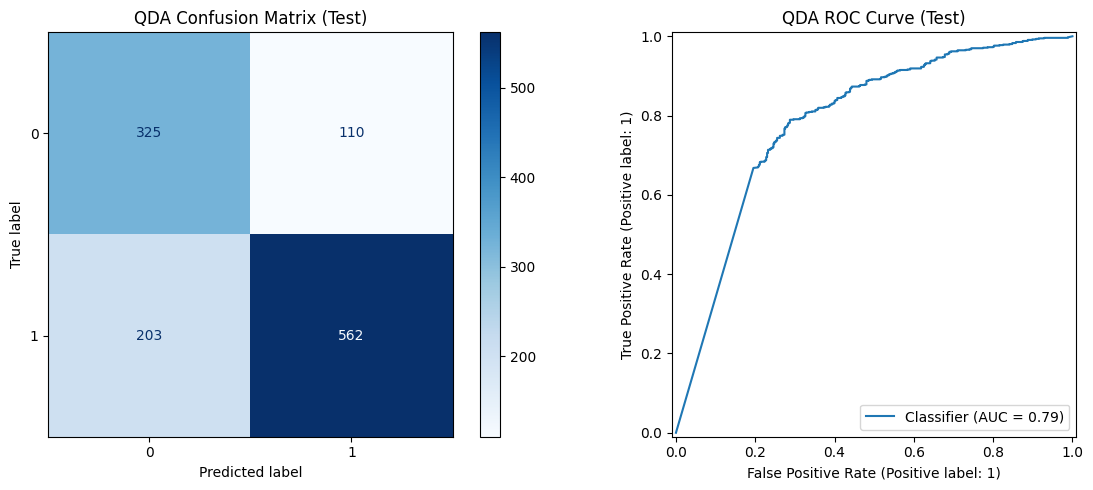

In [123]:
# QDA confusion matrix + ROC
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ConfusionMatrixDisplay.from_predictions(y_class_test, y_pred_qda_tuned, ax=ax[0], cmap="Blues")
ax[0].set_title("QDA Confusion Matrix (Test)")
RocCurveDisplay.from_predictions(y_class_test, y_proba_qda_tuned, ax=ax[1])
ax[1].set_title("QDA ROC Curve (Test)")
plt.tight_layout()
plt.show()

## 5.3 Tune KRR with `GridSearchCV`
- CV: 5-fold KFold
- Parameter grid: `model__alpha`, `model__gamma`
- Selection metric: negative RMSE


In [124]:
krr_pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("model", KernelRidge(kernel="rbf"))
])

# Regression CV (no stratification)
cv_reg = KFold(n_splits=5, shuffle=True, random_state=42)

param_grid_krr = {
    "model__alpha": [0.01, 0.1, 1.0, 10.0, 100.0],
    "model__gamma": [1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 5e-2]
}

# Use negative RMSE so GridSearchCV maximizes it
grid_krr = GridSearchCV(
    estimator=krr_pipe,
    param_grid=param_grid_krr,
    scoring="neg_root_mean_squared_error",
    cv=cv_reg,
    n_jobs=-1,
    verbose=0
)

grid_krr.fit(X_train, y_reg_train)

print("Best KRR params:", grid_krr.best_params_)
print("Best CV RMSE:", -grid_krr.best_score_)

Best KRR params: {'model__alpha': 0.1, 'model__gamma': 0.0001}
Best CV RMSE: 123700.79979705182


Show KRR grid-search results table (`alpha`, `gamma`, mean CV RMSE, rank).


In [125]:
# KRR CV results table
krr_cv = pd.DataFrame(grid_krr.cv_results_)[["param_model__alpha", "param_model__gamma", "mean_test_score", "rank_test_score"]]
krr_cv["mean_cv_rmse"] = -krr_cv["mean_test_score"]
krr_cv = krr_cv.sort_values("rank_test_score")
display(krr_cv[["param_model__alpha", "param_model__gamma", "mean_cv_rmse", "rank_test_score"]].head(10))

,param_model__alpha,param_model__gamma,mean_cv_rmse,rank_test_score
6,0.10,0.0001,123700.799797,1
13,1.00,0.0005,123905.960781,2
12,1.00,0.0001,124143.087997,3
14,1.00,0.0010,124580.380100,4
7,0.10,0.0005,126821.337084,5
0,0.01,0.0001,127105.902709,6
19,10.00,0.0005,127479.423188,7
20,10.00,0.0010,127580.171488,8
15,1.00,0.0050,128368.056570,9
8,0.10,0.0010,128418.308716,10


## 5.4 Evaluate tuned KRR on test set
Use the best estimator and report final test RMSE and R2.


In [126]:
best_krr = grid_krr.best_estimator_

pred_krr_tuned = best_krr.predict(X_test)

rmse_krr_tuned = np.sqrt(mean_squared_error(y_reg_test, pred_krr_tuned))
r2_krr_tuned = r2_score(y_reg_test, pred_krr_tuned)

print("Tuned KRR RMSE:", rmse_krr_tuned)
print("Tuned KRR R2:", r2_krr_tuned)

Tuned KRR RMSE: 198648.40928610845
Tuned KRR R2: 0.4612854026657943


Plot tuned KRR diagnostics on test data:
- Actual vs predicted scatter
- Residual vs predicted scatter


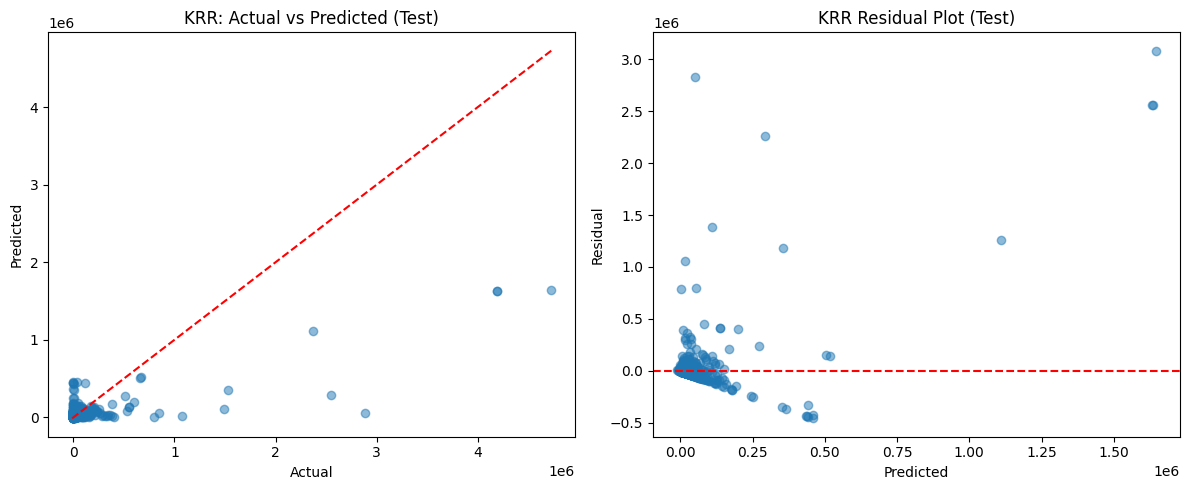

In [127]:
# KRR actual vs predicted + residuals
resid = y_reg_test - pred_krr_tuned

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].scatter(y_reg_test, pred_krr_tuned, alpha=0.5)
lims = [min(y_reg_test.min(), pred_krr_tuned.min()), max(y_reg_test.max(), pred_krr_tuned.max())]
ax[0].plot(lims, lims, "r--")
ax[0].set_xlabel("Actual")
ax[0].set_ylabel("Predicted")
ax[0].set_title("KRR: Actual vs Predicted (Test)")

ax[1].scatter(pred_krr_tuned, resid, alpha=0.5)
ax[1].axhline(0, color="r", linestyle="--")
ax[1].set_xlabel("Predicted")
ax[1].set_ylabel("Residual")
ax[1].set_title("KRR Residual Plot (Test)")

plt.tight_layout()
plt.show()

Create a final comparative summary table for both tasks and metrics.


In [128]:
summary = pd.DataFrame([
    {"Task": "Classification (QDA)", "Metric": "Accuracy", "Value": accuracy_score(y_class_test, y_pred_qda_tuned)},
    {"Task": "Classification (QDA)", "Metric": "F1", "Value": f1_score(y_class_test, y_pred_qda_tuned)},
    {"Task": "Classification (QDA)", "Metric": "ROC-AUC", "Value": roc_auc_score(y_class_test, y_proba_qda_tuned)},
    {"Task": "Regression (KRR)", "Metric": "RMSE", "Value": rmse_krr_tuned},
    {"Task": "Regression (KRR)", "Metric": "R2", "Value": r2_krr_tuned},
])
display(summary)

,Task,Metric,Value
0,Classification (QDA),Accuracy,0.739167
1,Classification (QDA),F1,0.782185
2,Classification (QDA),ROC-AUC,0.788330
3,Regression (KRR),RMSE,198648.409286
4,Regression (KRR),R2,0.461285


## 6. Explainability & interpretation
### 6.1 Permutation importance (QDA)
Estimate feature importance for the tuned QDA model using F1-based permutation importance.


,feature,importance_mean,importance_std
0,project_name,0.082585,0.011488
15,age,0.020592,0.005902
7,weighted_age,0.006741,0.001328
8,n_fix,0.006725,0.005288
16,size,0.006064,0.003153
14,avg_change_set,0.005833,0.001879
9,n_auth,0.000999,0.001130
35,num_buggy_files,0.000714,0.000693
11,max_churn,0.000381,0.001416
13,max_change_set,0.000328,0.002837


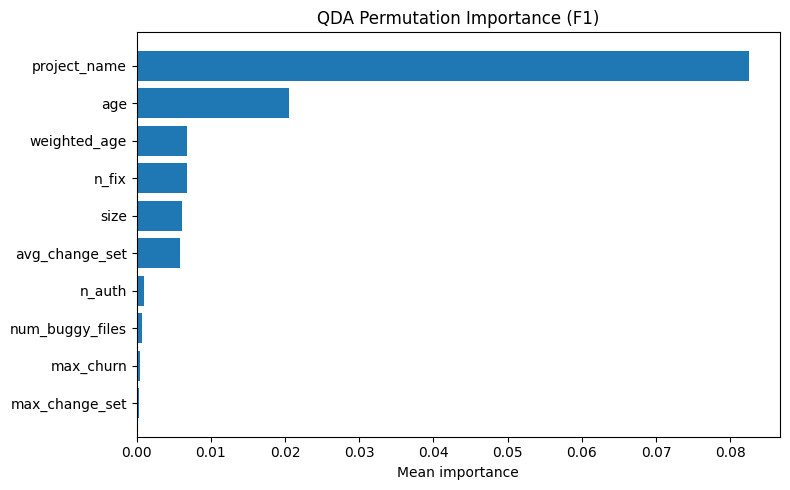

In [129]:
# -------- QDA (classification) --------
perm_qda = permutation_importance(
    best_qda,
    X_test,
    y_class_test,
    n_repeats=10,
    random_state=42,
    scoring="f1",
    n_jobs=-1
)

qda_imp = pd.DataFrame({
    "feature": X_test.columns,
    "importance_mean": perm_qda.importances_mean,
    "importance_std": perm_qda.importances_std
}).sort_values("importance_mean", ascending=False)

display(qda_imp.head(10))

plt.figure(figsize=(8, 5))
top_qda = qda_imp.head(10).sort_values("importance_mean")
plt.barh(top_qda["feature"], top_qda["importance_mean"])
plt.title("QDA Permutation Importance (F1)")
plt.xlabel("Mean importance")
plt.tight_layout()
plt.show()

### 6.2 Permutation importance (KRR)
Estimate feature importance for the tuned KRR model using RMSE-based permutation importance.


,feature,importance_mean,importance_std
3,t_lines,45007.416345,1882.238202
10,churn,7768.343471,332.793658
4,lines_added,6583.437039,278.636847
2,total_LOC,5565.082080,335.867766
16,size,3356.220942,302.064539
12,avg_churn,2146.346422,86.575846
34,num_methods,2123.501736,255.859924
33,num_files,1697.984425,372.629268
30,num_languages,1279.112470,217.045406
8,n_fix,1222.207184,173.366341


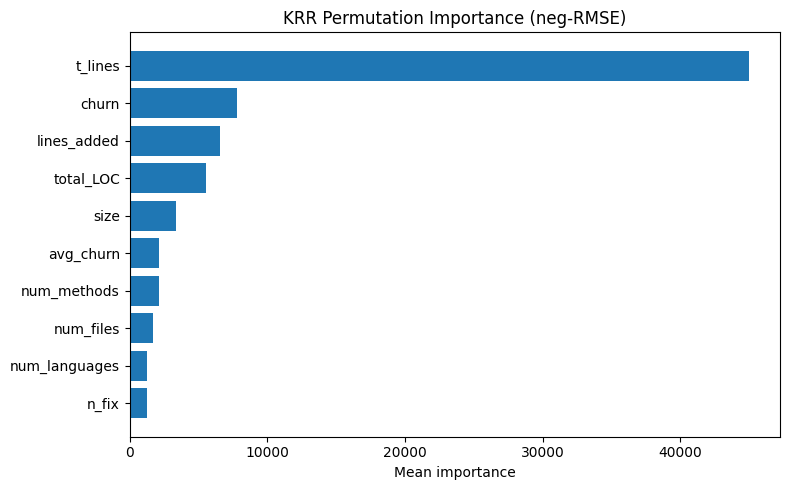

In [130]:
# -------- KRR (regression) --------
perm_krr = permutation_importance(
    best_krr,
    X_test,
    y_reg_test,
    n_repeats=10,
    random_state=42,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1
)

krr_imp = pd.DataFrame({
    "feature": X_test.columns,
    "importance_mean": perm_krr.importances_mean,
    "importance_std": perm_krr.importances_std
}).sort_values("importance_mean", ascending=False)

display(krr_imp.head(10))

plt.figure(figsize=(8, 5))
top_krr = krr_imp.head(10).sort_values("importance_mean")
plt.barh(top_krr["feature"], top_krr["importance_mean"])
plt.title("KRR Permutation Importance (neg-RMSE)")
plt.xlabel("Mean importance")
plt.tight_layout()
plt.show()


### 6.3 SHAP analysis (QDA)
Use `KernelExplainer` on sampled background/test subsets to explain class-1 probability predictions.


100%|██████████| 100/100 [00:52<00:00,  1.90it/s]


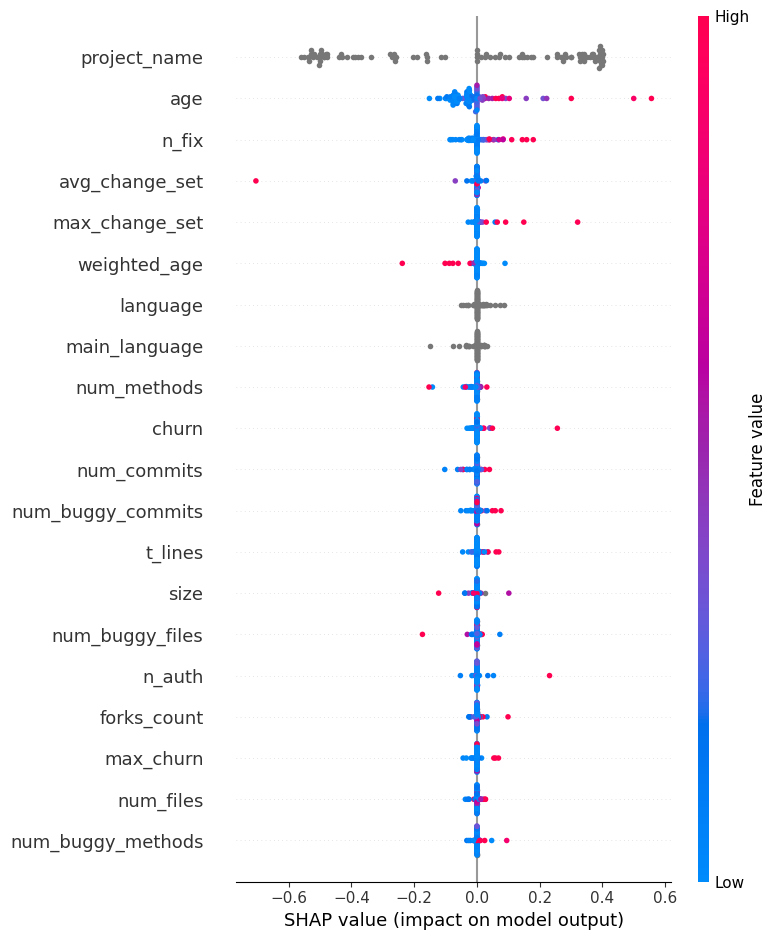

In [131]:
# Small background + explained samples (speed control)
X_bg = X_train.sample(100, random_state=42)
X_explain = X_test.sample(100, random_state=42)

# ---- QDA SHAP (classification, explain class-1 probability) ----
f_qda = lambda X: best_qda.predict_proba(pd.DataFrame(X, columns=X_train.columns))[:, 1]
explainer_qda = shap.KernelExplainer(f_qda, X_bg)
shap_vals_qda = explainer_qda.shap_values(X_explain, nsamples=100)

shap.summary_plot(shap_vals_qda, X_explain, feature_names=X_train.columns)

### 6.4 SHAP analysis (KRR)
Use `KernelExplainer` on sampled data to explain regression predictions; clip x-axis at the 99th percentile for readability.


100%|██████████| 100/100 [04:27<00:00,  2.67s/it]


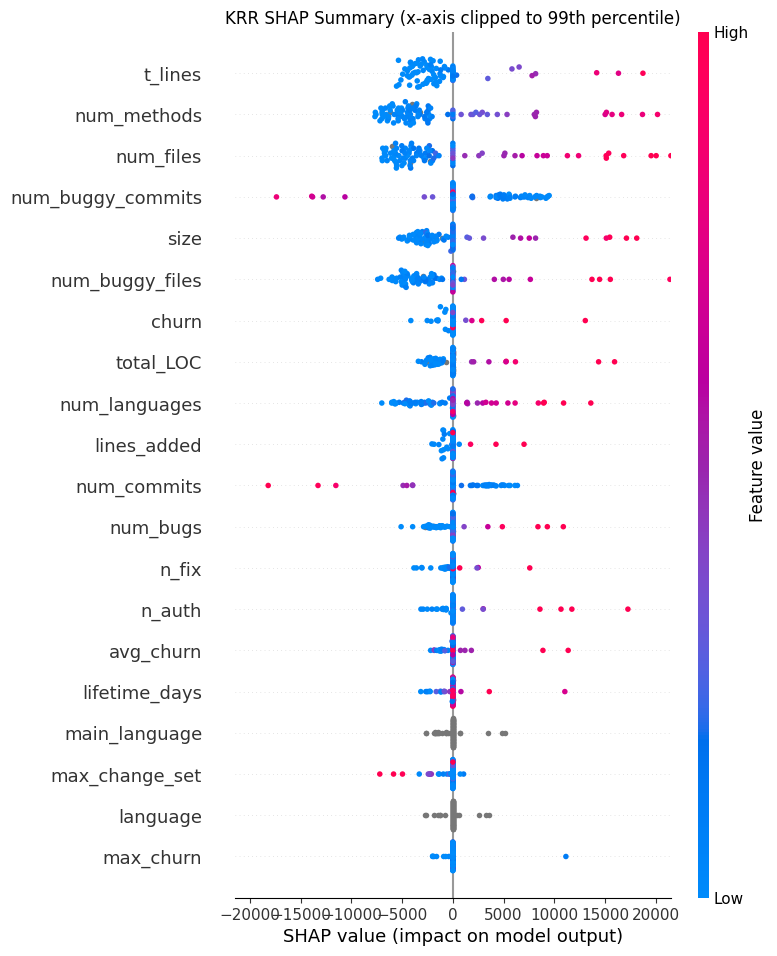

In [132]:
# ---- KRR SHAP (regression) ----
f_krr = lambda X: best_krr.predict(pd.DataFrame(X, columns=X_train.columns))
explainer_krr = shap.KernelExplainer(f_krr, X_bg)
shap_vals_krr = explainer_krr.shap_values(X_explain, nsamples=100)

# 1) Beeswarm with robust x-limits (outliers still exist, but no longer flatten the plot)
shap.summary_plot(shap_vals_krr, X_explain, feature_names=X_train.columns, show=False)
abs_vals = np.abs(np.asarray(shap_vals_krr)).ravel()
x_cap = np.percentile(abs_vals, 99)  # adjust (e.g., 95/98/99) if needed
plt.xlim(-x_cap, x_cap)
plt.title("KRR SHAP Summary (x-axis clipped to 99th percentile)")
plt.show()